#  AIDS Clinical Trials: A/B testing, A/B/n testing, multibandits, Thompson bootstrap

In [101]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

We will use to illustrate these techniques the AIDS Clinical Trials Group Study 175 Dataset that contains healthcare statistics and categorical information about patients who have been diagnosed with AIDS. This dataset was initially published in 1996. 

In [102]:
!pip3 install ucimlrepo
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
aids_clinical_trials_group_study_175 = fetch_ucirepo(id=890) 
  
# data (as pandas dataframes) 
X = aids_clinical_trials_group_study_175.data.features 
y = aids_clinical_trials_group_study_175.data.targets 
  
# metadata 
print(aids_clinical_trials_group_study_175.metadata) 
  
# variable information 
print(aids_clinical_trials_group_study_175.variables) 

{'uci_id': 890, 'name': 'AIDS Clinical Trials Group Study 175', 'repository_url': 'https://archive.ics.uci.edu/dataset/890/aids+clinical+trials+group+study+175', 'data_url': 'https://archive.ics.uci.edu/static/public/890/data.csv', 'abstract': 'The AIDS Clinical Trials Group Study 175 Dataset contains healthcare statistics and categorical information about patients who have been diagnosed with AIDS. This dataset was initially published in 1996. The prediction task is to predict whether or not each patient died within a certain window of time or not. ', 'area': 'Health and Medicine', 'tasks': ['Classification', 'Regression'], 'characteristics': ['Tabular', 'Multivariate'], 'num_instances': 2139, 'num_features': 23, 'feature_types': ['Categorical', 'Integer'], 'demographics': ['Age', 'Sexual Orientation', 'Race', 'Gender'], 'target_col': ['cid'], 'index_col': ['pidnum'], 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1996, 'last_updated': 'Fri Nov 

In [103]:
dfo = pd.concat([X, y], axis=1)
dfo

,time,trt,age,wtkg,hemo,homo,drugs,karnof,oprior,z30,...,str2,strat,symptom,treat,offtrt,cd40,cd420,cd80,cd820,cid
0,948,2,48,89.8128,0,0,0,100,0,0,...,0,1,0,1,0,422,477,566,324,0
1,1002,3,61,49.4424,0,0,0,90,0,1,...,1,3,0,1,0,162,218,392,564,1
2,961,3,45,88.4520,0,1,1,90,0,1,...,1,3,0,1,1,326,274,2063,1893,0
3,1166,3,47,85.2768,0,1,0,100,0,1,...,1,3,0,1,0,287,394,1590,966,0
4,1090,0,43,66.6792,0,1,0,100,0,1,...,1,3,0,0,0,504,353,870,782,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2134,1091,3,21,53.2980,1,0,0,100,0,1,...,1,3,0,1,1,152,109,561,720,0
2135,395,0,17,102.9672,1,0,0,100,0,1,...,1,3,0,0,1,373,218,1759,1030,0
2136,1104,2,53,69.8544,1,1,0,90,0,1,...,1,3,0,1,0,419,364,1391,1041,0
2137,465,0,14,60.0000,1,0,0,100,0,0,...,0,1,0,0,0,166,169,999,1838,1


We can ask the question: **does combination therapy A (zidovudine + didanosine) improve survival compared with zidovudine alone?**. 

Let's imagine that the treatments were given in the context of a randomized double-blind study.

We treat this as a simple A/B test:
* Group A: monotherapy (e.g., trt == 1, zidovudine alone)
* Group B: combination therapy (e.g., trt == 3, zidovudine + didanosine).

treatment indicator (0 = ZDV only; 1 = ZDV + ddI; 2 = ZDV + Zal; 3 = ddI only)	

In [104]:
df = dfo[dfo["trt"].isin([1, 3])].copy()
df["ttt"] = (df["trt"] == 3).astype(int)
df

,time,trt,age,wtkg,hemo,homo,drugs,karnof,oprior,z30,...,strat,symptom,treat,offtrt,cd40,cd420,cd80,cd820,cid,ttt
1,1002,3,61,49.4424,0,0,0,90,0,1,...,3,0,1,0,162,218,392,564,1,1
2,961,3,45,88.4520,0,1,1,90,0,1,...,3,0,1,1,326,274,2063,1893,0,1
3,1166,3,47,85.2768,0,1,0,100,0,1,...,3,0,1,0,287,394,1590,966,0,1
5,1181,1,46,88.9056,0,1,1,100,0,1,...,3,0,1,0,235,339,860,1060,0,0
8,198,3,40,82.5552,0,1,0,90,0,1,...,3,1,1,1,214,107,652,131,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2128,1101,3,25,65.0000,1,0,0,90,0,1,...,3,0,1,0,252,241,672,421,0,1
2131,948,1,20,72.4000,1,0,0,100,0,0,...,1,0,1,1,483,641,1728,1504,0,0
2132,413,3,27,80.2872,1,0,0,70,0,1,...,3,0,1,1,321,222,910,1009,0,1
2134,1091,3,21,53.2980,1,0,0,100,0,1,...,3,0,1,1,152,109,561,720,0,1


## A/B testing

The binary outcome is: survival at 96 weeks.

In [23]:
cutoff_days = 96 * 7
df["death_96w"] = np.where((df["cid"] == 1) & (df["time"] <= cutoff_days), 1, 0)
# survival indicator
df["surv_96w"] = 1 - df["death_96w"]
print(df[["trt", "ttt", "time", "cid", "death_96w", "surv_96w"]].head())

   trt  ttt  time  cid  death_96w  surv_96w
1    3    1  1002    1          0         1
2    3    1   961    0          0         1
3    3    1  1166    0          0         1
5    1    0  1181    0          0         1
8    3    1   198    1          1         0


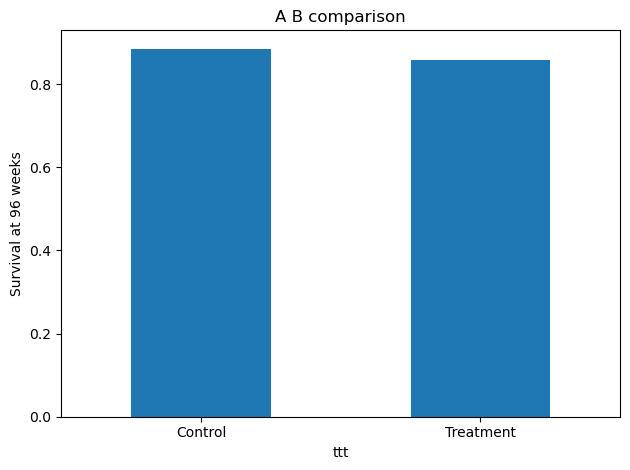

In [24]:
group_surv = (
    df.groupby("ttt")["surv_96w"]
    .mean()
    .rename(index={0: "Control", 1: "Treatment"})
)

fig, ax = plt.subplots()
group_surv.plot(kind="bar", ax=ax)
ax.set_ylabel("Survival at 96 weeks")
ax.set_title("A B comparison")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [25]:
p1 = df.loc[df["ttt"] == 0, "surv_96w"].mean()
p2 = df.loc[df["ttt"] == 1, "surv_96w"].mean()

n1 = df.loc[df["ttt"] == 0].shape[0]
n2 = df.loc[df["ttt"] == 1].shape[0]

print("p1:", p1)
print("p2:", p2)
print("n1:", n1, "n2:", n2)

p1: 0.8850574712643678
p2: 0.857397504456328
n1: 522 n2: 561


In [26]:
diff = p2 - p1

se = np.sqrt(
    p1 * (1 - p1) / n1 +
    p2 * (1 - p2) / n2
)

z = diff / se
p_value = 2 * (1 - stats.norm.cdf(abs(z)))

zcrit = stats.norm.ppf(0.975)
ci_low = diff - zcrit * se
ci_high = diff + zcrit * se

print("Difference:", diff)
print("z:", z)
print("p value:", p_value)
print("95 percent CI:", (ci_low, ci_high))

Difference: -0.027659966808039838
z: -1.3613361075134522
p value: 0.1734074972707107
95 percent CI: (np.float64(-0.06748300423290715), np.float64(0.012163070616827476))


We observe a large CI and a high p value, so there is no statistical evidence of a difference in survival at 96 weeks between the two arms.

### **Sample size**

If the data as prospectively collected and we wanted to calculate the sample size for detecting +5 percent absolute improvement at 96 weeks

In [28]:
p2_target = p1 + 0.05
from statsmodels.stats.power import NormalIndPower
from statsmodels.stats.proportion import proportion_effectsize

alpha = 0.05
power = 0.80

p2_target = p1 + 0.05

if p2_target >= 1:
    raise ValueError("p2_target must be less than 1")

#We compute Cohen’s standardized effect size h for two proportions p1 and p2
effect = proportion_effectsize(p1, p2_target)

analysis = NormalIndPower()
n_per_group = analysis.solve_power(
    effect_size=effect,
    alpha=alpha,
    power=power,
    ratio=1
)

n_per_group_round = int(np.ceil(n_per_group))

print("Required per group:", n_per_group_round)
print("Total:", 2 * n_per_group_round)

Required per group: 505
Total: 1010


Interestingly, we had the right sample size to measure an effect of +5 percent absolute improvement at 96 weeks.
In this scenario, the study was sufficiently powered for the hypothesized +5 percent improvement, but the observed data provide no evidence of benefit and actually would be even more consistent with no effect or mild harm (negative difference).

### **Logistic regression**

We can look at the logistic regression then check if the assumptions seem respected.

In this model we see again no evidence of benefit and even results more consistent with no effect or mild harm (negative difference).



In [48]:
import statsmodels.formula.api as smf

# Choose some baseline covariates present in your dataset
covariates = ['age', 'wtkg', 'hemo', 'homo', 'drugs', 'karnof', 'gender',  'strat',
       'symptom', 'offtrt', 'cd40', 'cd420', 'cd80', 'cd820']  

cols = ["surv_96w", "ttt"] + covariates
reg_df = df[cols].dropna()

model = smf.logit("surv_96w ~ ttt + age + wtkg + hemo + homo + drugs + karnof  + gender +  strat + symptom + offtrt + cd40 + cd420 + cd80 + cd820 ", data=reg_df).fit()
print(model.summary())

# Adjusted odds ratio for treatment B vs A
params = model.params
conf = model.conf_int()

or_treat = np.exp(params["ttt"])
or_low = np.exp(conf.loc["ttt", 0])
or_high = np.exp(conf.loc["ttt", 1])

print("Adjusted OR for survival (B vs A):", or_treat)
print("95 percent CI:", (or_low, or_high))

Optimization terminated successfully.
         Current function value: 0.296695
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:               surv_96w   No. Observations:                 1083
Model:                          Logit   Df Residuals:                     1067
Method:                           MLE   Df Model:                           15
Date:                Thu, 04 Dec 2025   Pseudo R-squ.:                  0.2294
Time:                        13:54:48   Log-Likelihood:                -321.32
converged:                       True   LL-Null:                       -416.95
Covariance Type:            nonrobust   LLR p-value:                 1.258e-32
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -3.7671      1.756     -2.145      0.032      -7.209      -0.326
ttt           -0.0555      0.

### **Continuous IVs being Linearly Related to the Log Odds**

We can perform **Box-Tidwell tests** for continuous variables.

In [58]:
df_bt = df[["surv_96w", 'ttt', 'age', 'wtkg', 'karnof',  'strat', 'cd40', 'cd420', 'cd80', 'cd820']].dropna().copy()

# Box–Tidwell requires strictly > 0 for log()
for v in ['age', 'wtkg', 'karnof',  'strat', 'cd40', 'cd420', 'cd80', 'cd820']:
    df_bt = df_bt[df_bt[v] > 0]
#Create interaction terms
for v in ['age', 'wtkg', 'karnof',  'strat', 'cd40', 'cd420', 'cd80', 'cd820']:
    df_bt[f"{v}_log"] = df_bt[v] * np.log(df_bt[v])

formula_bt = (
    "surv_96w ~ ttt "
    "+ age + age_log "
    "+ wtkg + wtkg_log"
    "+ karnof + karnof_log "
    "+ strat + strat_log "
    "+ cd40 + cd40_log "
    "+ cd420 + cd420_log "
    "+ cd80 + cd80_log "
    "+ cd820 + cd820_log "
    
)

bt_model = smf.logit(formula_bt, data=df_bt).fit()
print(bt_model.summary())

Optimization terminated successfully.
         Current function value: 0.302268
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:               surv_96w   No. Observations:                 1080
Model:                          Logit   Df Residuals:                     1062
Method:                           MLE   Df Model:                           17
Date:                Thu, 04 Dec 2025   Pseudo R-squ.:                  0.2163
Time:                        14:02:08   Log-Likelihood:                -326.45
converged:                       True   LL-Null:                       -416.54
Covariance Type:            nonrobust   LLR p-value:                 2.664e-29
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -4.7809     34.781     -0.137      0.891     -72.951      63.389
ttt           -0.0060      0.

The only p value that is problematic for the interaction terms is cd420_log so cd420 may not be linearly related to log-odds. We would need to transform this variable.
We can visualize it in the plot below.

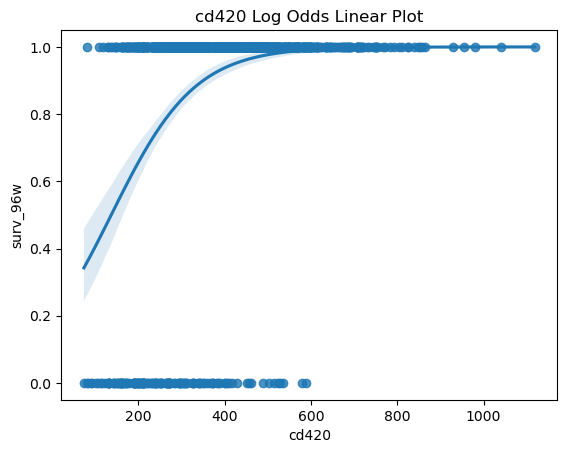

In [59]:
import seaborn as sns
surv = sns.regplot(x= 'cd420', y= 'surv_96w', data= df, logistic= True).set_title("cd420 Log Odds Linear Plot")
surv.figure.savefig("cd420 log lin.png")

Interestingly, when we drop cd420, we see the p value for ttt drop, even if it stays still above the common 5% threshold.

In [60]:
import statsmodels.formula.api as smf

# Choose some baseline covariates present in your dataset
covariates = ['age', 'wtkg', 'hemo', 'homo', 'drugs', 'karnof', 'gender',  'strat',
       'symptom', 'offtrt', 'cd40',  'cd80', 'cd820']  

cols = ["surv_96w", "ttt"] + covariates
reg_df = df[cols].dropna()

model = smf.logit("surv_96w ~ ttt + age + wtkg + hemo + homo + drugs + karnof  + gender +  strat + symptom + offtrt + cd40  + cd80 + cd820 ", data=reg_df).fit()
print(model.summary())

# Adjusted odds ratio for treatment B vs A
params = model.params
conf = model.conf_int()

or_treat = np.exp(params["ttt"])
or_low = np.exp(conf.loc["ttt", 0])
or_high = np.exp(conf.loc["ttt", 1])

print("Adjusted OR for survival (B vs A):", or_treat)
print("95 percent CI:", (or_low, or_high))

Optimization terminated successfully.
         Current function value: 0.337409
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:               surv_96w   No. Observations:                 1083
Model:                          Logit   Df Residuals:                     1068
Method:                           MLE   Df Model:                           14
Date:                Thu, 04 Dec 2025   Pseudo R-squ.:                  0.1236
Time:                        14:07:12   Log-Likelihood:                -365.41
converged:                       True   LL-Null:                       -416.95
Covariance Type:            nonrobust   LLR p-value:                 1.216e-15
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.7478      1.682     -1.633      0.102      -6.045       0.550
ttt           -0.3263      0.

### **Lack of outliers**
**Cook’s Distance** measures how much each observation influences the regression coefficients. Here we see some influential observations in the graph which are gathered as large bars in the graph below. It would be important to review these observations as a knowledge expert to ensure the data is valid and not some kind of error.

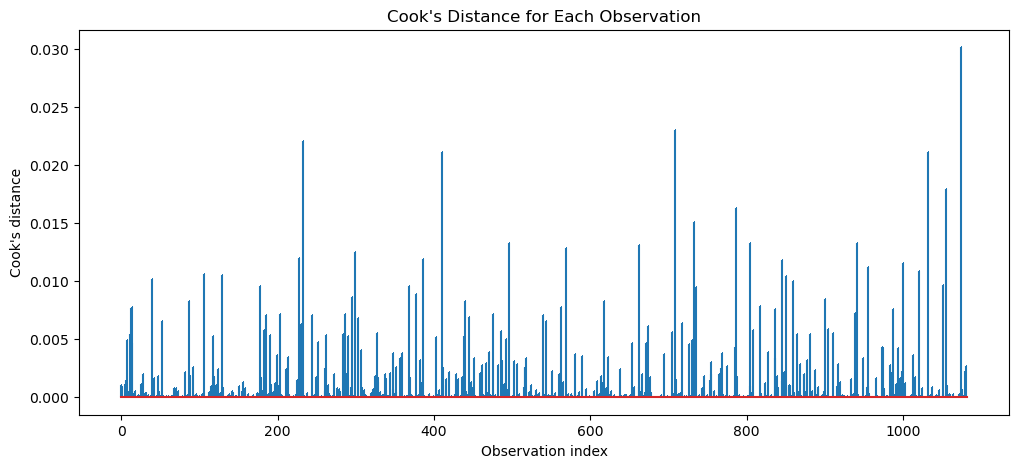

Influential observations (Cook’s D > 4/n): 92 points


In [49]:
# Influence measures
influence = model.get_influence()

# Cook’s distance values
cooks_d = influence.cooks_distance[0]

# Plot Cook’s Distance
plt.figure(figsize=(12,5))
plt.stem(np.arange(len(cooks_d)), cooks_d, markerfmt=",")   
plt.xlabel("Observation index")
plt.ylabel("Cook's distance")
plt.title("Cook's Distance for Each Observation")
plt.show()

# Optional: Flag influential observations
influential_points = np.where(cooks_d > 4/len(cooks_d))[0]
print("Influential observations (Cook’s D > 4/n):", len(influential_points),'points')

### **Independance**
To check for independence, we can review the **variance inflation factor (VIF)** that quantifies how much the variance is inflated: the standard errors  and hence the variances of the estimated coefficients are inflated when multicollinearity exists. A variance inflation factor exists for each of the predictors in a multiple regression model. The general rule of thumb is that VIFs exceeding 4 warrant further investigation, while VIFs exceeding 10 are signs of serious multicollinearity requiring correction. 

Here we decided to drop str2 from the model.

In [52]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Select predictors only
X = df[['ttt', 'age', 'wtkg', 'hemo', 'homo', 'drugs', 'karnof',  'gender', 'str2', 'strat', 'symptom', 'offtrt', 'cd40', 'cd420', 'cd80', 'cd820']]

# Remove rows with NaN or infinite values
X = X.replace([np.inf, -np.inf], np.nan).dropna()

# Add constant term
X_const = sm.add_constant(X)

# Compute VIF
vif_data = pd.DataFrame()
vif_data["Variable"] = X_const.columns
vif_data["VIF"] = [
    variance_inflation_factor(X_const.values, i)
    for i in range(X_const.shape[1])
]

print(vif_data)

   Variable         VIF
0     const  355.544860
1       ttt    1.023798
2       age    1.138024
3      wtkg    1.180883
4      hemo    1.765663
5      homo    2.659914
6     drugs    1.105365
7    karnof    1.038589
8    gender    2.314179
9      str2    6.478634
10    strat    6.534333
11  symptom    1.054080
12   offtrt    1.074655
13     cd40    1.857533
14    cd420    2.004428
15     cd80    3.110551
16    cd820    3.070091


In [53]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Select predictors only
X = df[['ttt', 'age', 'wtkg', 'hemo', 'homo', 'drugs', 'karnof',  'gender',  'strat', 'symptom', 'offtrt', 'cd40', 'cd420', 'cd80', 'cd820']]

# Remove rows with NaN or infinite values
X = X.replace([np.inf, -np.inf], np.nan).dropna()

# Add constant term
X_const = sm.add_constant(X)

# Compute VIF
vif_data = pd.DataFrame()
vif_data["Variable"] = X_const.columns
vif_data["VIF"] = [
    variance_inflation_factor(X_const.values, i)
    for i in range(X_const.shape[1])
]

print(vif_data)

   Variable         VIF
0     const  355.363178
1       ttt    1.022026
2       age    1.136047
3      wtkg    1.179998
4      hemo    1.765641
5      homo    2.657619
6     drugs    1.105356
7    karnof    1.032903
8    gender    2.293542
9     strat    1.118666
10  symptom    1.053647
11   offtrt    1.074544
12     cd40    1.852700
13    cd420    1.990433
14     cd80    3.084744
15    cd820    3.047990


## A/B/n Testing

**Arms**

* Arm 1: zidovudine

* Arm 2: zidovudine + zalcitabine

* Arm 3: zidovudine + didanosine

* Arm 4: didanosine

**Reward definition**

* reward = 1 if alive at 96 weeks

* reward = 0 otherwise

In [84]:
bdf = dfo
bdf["death_96w"] = np.where((bdf["cid"] == 1) & (bdf["time"] <= cutoff_days), 1, 0)

# survival indicator
bdf["surv_96w"] = 1 - bdf["death_96w"]
bdf = bdf[["trt", "surv_96w"]].dropna().copy()
# Check basic structure
print(bdf.head())
print(bdf["trt"].value_counts())
# Arms present in the data
arms = sorted(bdf["trt"].unique())
n_arms = len(arms)

# Map arm labels (e.g. 0,1,2,3 or 1,2,3,4) to indices 0...(n_arms-1)
arm_index = {arm: i for i, arm in enumerate(arms)}

# For quick access: list of rewards per arm from the raw data
rewards_by_arm = [[] for _ in range(n_arms)]

for _, row in bdf.iterrows():
    a = arm_index[row["trt"]]
    rewards_by_arm[a].append(row["surv_96w"])

   trt  surv_96w
0    2         1
1    3         1
2    3         1
3    3         1
4    0         1
trt
3    561
0    532
2    524
1    522
Name: count, dtype: int64


In [87]:
summary = (
    bdf.groupby("trt")["surv_96w"]
    .agg(["mean", "count", "sum"])
    .rename(columns={"mean": "survival_96w", "count": "n", "sum": "alive"})
)

print(summary)

     survival_96w    n  alive
trt                          
0        0.765038  532    407
1        0.885057  522    462
2        0.891221  524    467
3        0.857398  561    481


In [89]:
# Build contingency table: rows = arms, columns = [alive, dead]
cont_table = pd.crosstab(bdf["trt"], bdf["surv_96w"])
# Ensure columns are in order [0, 1] or [dead, alive]
cont_table = cont_table[[0, 1]]

chi2, p_global, dof, expected = stats.chi2_contingency(cont_table)

print("Chi square statistic:", chi2)
print("Degrees of freedom:", dof)
print("Global p value:", p_global)

Chi square statistic: 42.246498125399796
Degrees of freedom: 3
Global p value: 3.556825301821436e-09


In [92]:
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats.multitest import multipletests

arms = sorted(bdf["trt"].unique())
pair_results = []

for i in range(len(arms)):
    for j in range(i + 1, len(arms)):
        a = arms[i]
        b = arms[j]
        
        # Counts of successes and totals
        sub = bdf[bdf["trt"].isin([a, b])]
        
        successes = sub.groupby("trt")["surv_96w"].sum().loc[[a, b]].values
        counts = sub.groupby("trt")["surv_96w"].count().loc[[a, b]].values
        
        stat, p = proportions_ztest(successes, counts)
        
        p1 = successes[0] / counts[0]
        p2 = successes[1] / counts[1]
        diff = p2 - p1
        
        pair_results.append({
            "arm_a": a,
            "arm_b": b,
            "p1": p1,
            "p2": p2,
            "diff_p2_minus_p1": diff,
            "z_stat": stat,
            "p_raw": p
        })

pair_df = pd.DataFrame(pair_results)

# Adjust p values for multiple comparisons (Holm or Bonferroni)
reject, p_adj, _, _ = multipletests(pair_df["p_raw"], method="holm")
pair_df["p_adj"] = p_adj
pair_df["reject_at_0.05"] = reject

print(pair_df.sort_values("p_adj"))

   arm_a  arm_b        p1        p2  diff_p2_minus_p1    z_stat         p_raw  \
1      0      2  0.765038  0.891221          0.126184 -5.428321  5.688658e-08   
0      0      1  0.765038  0.885057          0.120020 -5.121165  3.036532e-07   
2      0      3  0.765038  0.857398          0.092360 -3.909736  9.239710e-05   
5      2      3  0.891221  0.857398         -0.033824  1.676180  9.370284e-02   
4      1      3  0.885057  0.857398         -0.027660  1.355697  1.751955e-01   
3      1      2  0.885057  0.891221          0.006164 -0.316244  7.518176e-01   

          p_adj  reject_at_0.05  
1  3.413195e-07            True  
0  1.518266e-06            True  
2  3.695884e-04            True  
5  2.811085e-01           False  
4  3.503911e-01           False  
3  7.518176e-01           False  


In [93]:
logit_mod = smf.logit("surv_96w ~ C(trt)", data=bdf).fit()
print(logit_mod.summary())

Optimization terminated successfully.
         Current function value: 0.414357
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:               surv_96w   No. Observations:                 2139
Model:                          Logit   Df Residuals:                     2135
Method:                           MLE   Df Model:                            3
Date:                Thu, 04 Dec 2025   Pseudo R-squ.:                 0.02191
Time:                        17:16:22   Log-Likelihood:                -886.31
converged:                       True   LL-Null:                       -906.17
Covariance Type:            nonrobust   LLR p-value:                 1.225e-08
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       1.1805      0.102     11.544      0.000       0.980       1.381
C(trt)[T.1]     0.8607    

In [94]:
params = logit_mod.params
conf = logit_mod.conf_int()
or_table = pd.DataFrame({
    "coef": params,
    "OR": np.exp(params),
    "CI_low": np.exp(conf[0]),
    "CI_high": np.exp(conf[1])
})
print(or_table)

                 coef        OR    CI_low   CI_high
Intercept    1.180499  3.256000  2.664655  3.978578
C(trt)[T.1]  0.860721  2.364865  1.690961  3.307342
C(trt)[T.2]  0.922779  2.516272  1.790508  3.536218
C(trt)[T.3]  0.613341  1.846591  1.354213  2.517992


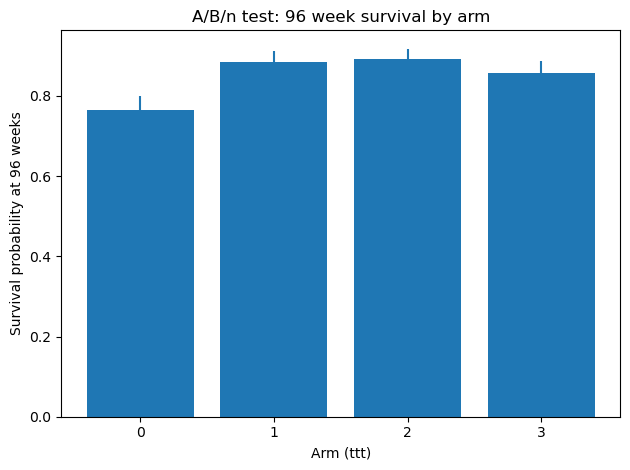

In [97]:
# Compute mean and standard error
group = bdf.groupby("trt")["surv_96w"].agg(["mean", "count"])
group["se"] = np.sqrt(group["mean"] * (1 - group["mean"]) / group["count"])
z_crit = stats.norm.ppf(0.975)
group["ci_low"] = group["mean"] - z_crit * group["se"]
group["ci_high"] = group["mean"] + z_crit * group["se"]

plt.figure()
plt.bar(group.index.astype(str), group["mean"])
plt.errorbar(
    group.index.astype(str),
    group["mean"],
    yerr=z_crit * group["se"],
    fmt="none",
)
plt.xlabel("Arm (ttt)")
plt.ylabel("Survival probability at 96 weeks")
plt.title("A/B/n test: 96 week survival by arm")
plt.tight_layout()
plt.show()

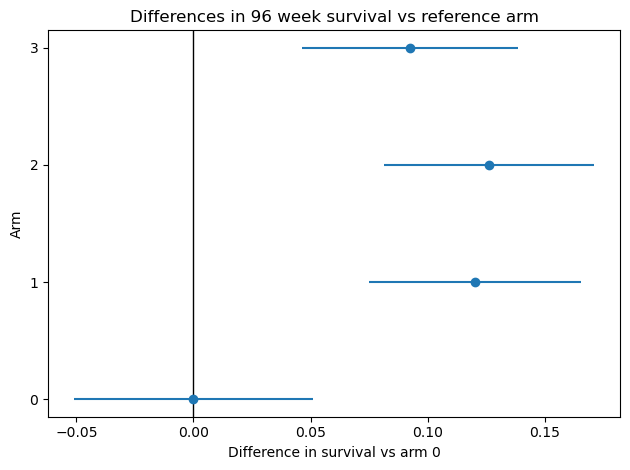

In [98]:
ref_arm = arms[0]

effects = []
for a in arms:
    sub = bdf[bdf["trt"].isin([ref_arm, a])]
    successes = sub.groupby("trt")["surv_96w"].sum().loc[[ref_arm, a]].values
    counts = sub.groupby("trt")["surv_96w"].count().loc[[ref_arm, a]].values
    p_ref = successes[0] / counts[0]
    p_a = successes[1] / counts[1]
    diff = p_a - p_ref
    se = np.sqrt(
        p_ref * (1 - p_ref) / counts[0]
        + p_a * (1 - p_a) / counts[1]
    )
    ci_low = diff - z_crit * se
    ci_high = diff + z_crit * se
    effects.append({
        "arm": a,
        "diff_vs_ref": diff,
        "ci_low": ci_low,
        "ci_high": ci_high
    })

eff_df = pd.DataFrame(effects).set_index("arm")

plt.figure()
plt.errorbar(
    eff_df["diff_vs_ref"],
    eff_df.index.astype(str),
    xerr=[
        eff_df["diff_vs_ref"] - eff_df["ci_low"],
        eff_df["ci_high"] - eff_df["diff_vs_ref"],
    ],
    fmt="o",
)
plt.axvline(0, color="k", linewidth=1)
plt.xlabel(f"Difference in survival vs arm {ref_arm}")
plt.ylabel("Arm")
plt.title("Differences in 96 week survival vs reference arm")
plt.tight_layout()
plt.show()

All three treatment arms (1, 2, 3) show significantly higher 96-week survival odds than the reference arm. Arm 2 has the largest effect, followed by Arm 1, then Arm 3. None of the confidence intervals cross 1, so all differences vs the reference are statistically significant under the model.

#### **Sampling**

Let's use the zidovudine group as our reference and explore calculations if we had to calculate our sample sizes for this A/B/n testing

In [100]:
from statsmodels.stats.power import NormalIndPower
from statsmodels.stats.proportion import proportion_effectsize


tmp = bdf[["trt", "surv_96w"]].dropna()
arm_means = tmp.groupby("trt")["surv_96w"].mean()
ref_arm = arm_means.idxmin()
p_ref = arm_means.loc[ref_arm]

print("Planning reference arm:", ref_arm)
print("Baseline survival p_ref:", p_ref)


Planning reference arm: 0
Baseline survival p_ref: 0.7650375939849624


In [106]:
# Define A/B/n design parameters ---

k = tmp["trt"].nunique()     # number of arms
delta = 0.05                 # minimal absolute difference to detect
power = 0.80
alpha_global = 0.05

# Number of pairwise comparisons
m_pairs = k * (k - 1) // 2

# Bonferroni per-comparison alpha
alpha_per = alpha_global / m_pairs

print("Number of arms:", k)
print("Number of pairwise comparisons:", m_pairs)
print("Per-comparison alpha (Bonferroni):", alpha_per)

# --- 3. Two-proportion sample size for p_ref vs p_ref + delta ---

p1 = p_ref
p2 = p_ref + delta
if p2 >= 1:
    raise ValueError("p_ref + delta must be < 1; adjust assumptions.")

effect = proportion_effectsize(p1, p2)  # Cohen's h

analysis = NormalIndPower()
n_per_arm = analysis.solve_power(
    effect_size=effect,
    power=power,
    alpha=alpha_per,
    ratio=1
)

n_per_arm_round = int(np.ceil(n_per_arm))
N_total = k * n_per_arm_round

print("Required per arm (unrounded):", n_per_arm)
print("Required per arm (rounded):", n_per_arm_round)
print("Total required (k arms):", N_total)

Number of arms: 4
Number of pairwise comparisons: 6
Per-comparison alpha (Bonferroni): 0.008333333333333333
Required per arm (unrounded): 1601.8608990765078
Required per arm (rounded): 1602
Total required (k arms): 6408


With 4 treatment strategies and interest in all 6 pairwise comparisons, controlling the overall type I error at 5 percent using Bonferroni, if we to detect a 5 % difference in 96 week survival, this translates into a sample size around 6400 patients.


### Multibandits arms / ε greedy policy

Compared to the previous examples where sampling happens at the same starting time, the multi-armed bandit would wait to estimate the 96 weeks survival of each subject before associating the treatment to the next subject. Of course, this is not realistic. The idea would be to increase the overall survival of the group of tested patients 
Just for an illustrative purpose, let's look at the overall evolution of the 96 weeks survival proportion of the whole group as each subject is "drawn" in the case above.

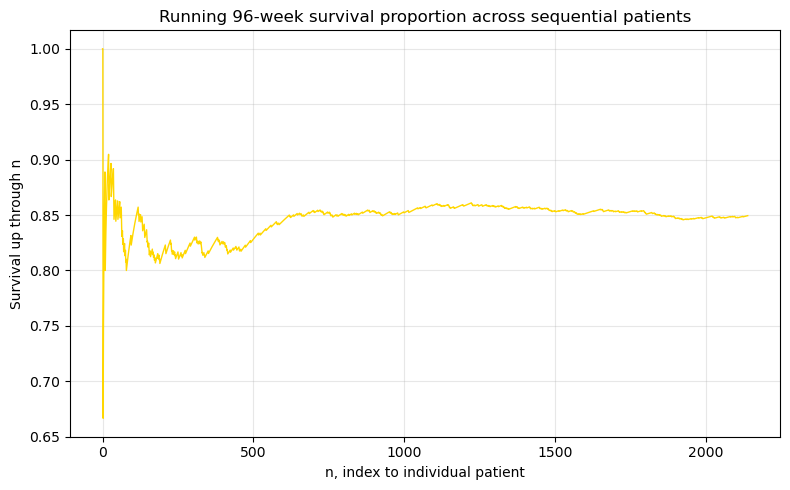

Overall cohort survival rate at 96 weeks: surv_96w    0.849462
dtype: float64


In [109]:
# bdf must contain surv_96w (0/1)
bdf = bdf[["surv_96w"]].dropna().copy()

# Shuffle patients to simulate sequential arrival
np.random.seed(1)
bdf_seq = bdf.sample(frac=1).reset_index(drop=True)

# Compute cumulative survival proportion
rewards = bdf_seq["surv_96w"].values
cum_mean = np.cumsum(rewards) / (np.arange(len(rewards)) + 1)

plt.figure(figsize=(8,5))
plt.plot(cum_mean, color="gold", linewidth=1)
plt.xlabel("n, index to individual patient")
plt.ylabel("Survival up through n")
plt.title("Running 96-week survival proportion across sequential patients")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

overall_survival_rate = bdf.mean()

print("Overall cohort survival rate at 96 weeks:", overall_survival_rate)

We imagine the same total number of patients will be assigned to one of the treatment arms according to a multibandit policy, based on the survival proportions for each arm from the database.
The ε greedy policy chooses a random arm with probability ε, and with probability 1−ε, it picks the arm with the highest empirical mean.

True survival probs per arm: [0.765038 0.885057 0.891221 0.857398]
Total patients N: 2139


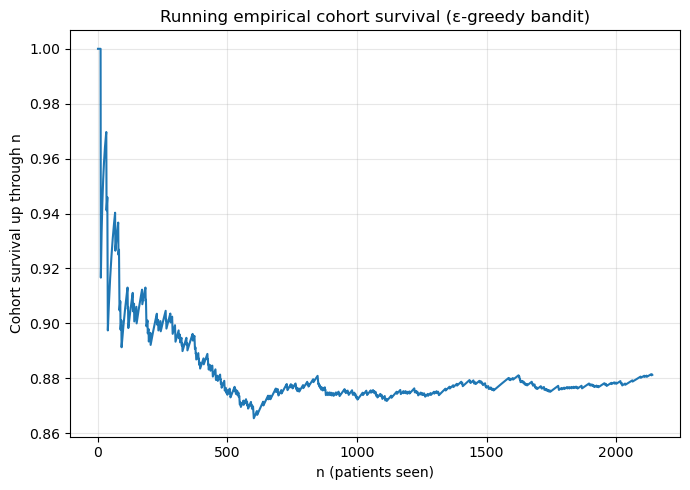

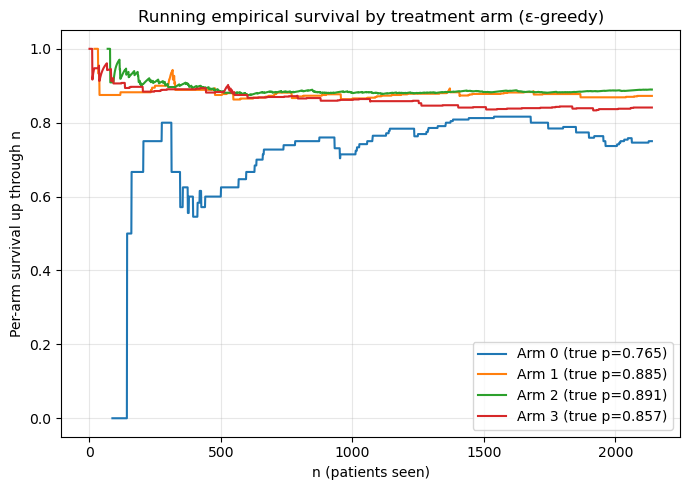

Final simulated overall cohort survival rate: 0.8812529219261337
Final per-arm counts: [  64  102 1822  151]
Final per-arm estimated survival: [0.75       0.87254902 0.88968167 0.8410596 ]


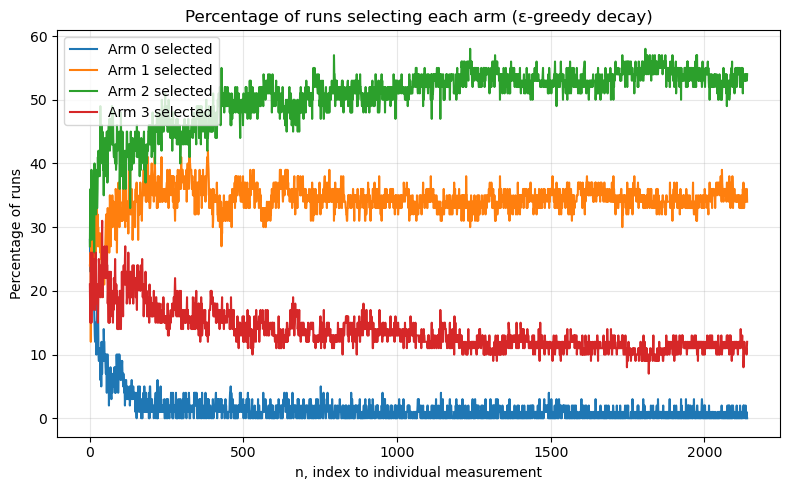

In [112]:
true_p = np.array([0.765038, 0.885057, 0.891221, 0.857398])
n_per_arm = np.array([532, 522, 524, 561])   # only used to match total N
arms = np.arange(len(true_p))
K = len(arms)

N = int(n_per_arm.sum())   # total number of patients (2139)

print("True survival probs per arm:", true_p)
print("Total patients N:", N)

epsilon = 0.1

counts = np.zeros(K, dtype=int)          # how many times each arm chosen
sum_rewards = np.zeros(K, dtype=float)   # total survival per arm
value_estimates = np.zeros(K, dtype=float)

overall_cum = np.zeros(N)                    # running overall survival
per_arm_cum = np.full((N, K), np.nan)        # running per-arm survival estimates

total_reward = 0
rng = np.random.default_rng(1)

for t in range(N):
    # choose arm: explore with prob epsilon, otherwise exploit
    if rng.random() < epsilon and t > 0:
        a = rng.integers(K)
    else:
        if t == 0:
            a = rng.integers(K)
        else:
            max_val = value_estimates.max()
            candidate_arms = np.flatnonzero(value_estimates == max_val)
            a = rng.choice(candidate_arms)

    # simulate survival outcome from Bernoulli(true_p[a])
    reward = 1 if rng.random() < true_p[a] else 0

    # update per-arm stats
    counts[a] += 1
    sum_rewards[a] += reward
    value_estimates[a] = sum_rewards[a] / counts[a]

    # update overall
    total_reward += reward
    overall_cum[t] = total_reward / (t + 1)

    # store per-arm cumulative means (NaN where arm not yet sampled)
    for k in range(K):
        if counts[k] > 0:
            per_arm_cum[t, k] = sum_rewards[k] / counts[k]

# Overall cohort running survival
plt.figure(figsize=(7, 5))
plt.plot(np.arange(1, N + 1), overall_cum)
plt.xlabel("n (patients seen)")
plt.ylabel("Cohort survival up through n")
plt.title("Running empirical cohort survival (ε-greedy bandit)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Per-arm running survival estimates
plt.figure(figsize=(7, 5))
for k in range(K):
    plt.plot(np.arange(1, N + 1), per_arm_cum[:, k],
             label=f"Arm {k} (true p={true_p[k]:.3f})")
plt.xlabel("n (patients seen)")
plt.ylabel("Per-arm survival up through n")
plt.title("Running empirical survival by treatment arm (ε-greedy)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Final overall cohort survival rate from the simulation
final_overall_surv = overall_cum[-1]
print("Final simulated overall cohort survival rate:", final_overall_surv)
print("Final per-arm counts:", counts)
print("Final per-arm estimated survival:", value_estimates)


# Percentage of runs that select each arm at each measurement
n_runs = 100
T = N
rng2 = np.random.default_rng(123)

# choices[r, t] = arm chosen in run r at time t
choices = np.zeros((n_runs, T), dtype=int)

for r in range(n_runs):
    counts_r = np.zeros(K, dtype=int)
    values_r = np.zeros(K, dtype=float)

    for t in range(T):
        # decaying epsilon
        eps_t = 1.0 / np.sqrt(t + 1)

        if rng2.random() < eps_t:
            a = rng2.integers(K)
        else:
            if t == 0:
                a = rng2.integers(K)
            else:
                max_val = values_r.max()
                best_arms = np.flatnonzero(values_r == max_val)
                a = rng2.choice(best_arms)

        reward = 1 if rng2.random() < true_p[a] else 0

        counts_r[a] += 1
        values_r[a] += (reward - values_r[a]) / counts_r[a]

        choices[r, t] = a

# percentage of runs selecting each arm
perc = np.zeros((T, K))
for k in range(K):
    perc[:, k] = (choices == k).mean(axis=0) * 100.0

# Plot percentage of runs selecting each arm
x = np.arange(1, T + 1)

plt.figure(figsize=(8, 5))
for k in range(K):
    plt.plot(x, perc[:, k], label=f"Arm {k} selected")
plt.xlabel("n, index to individual measurement")
plt.ylabel("Percentage of runs")
plt.title("Percentage of runs selecting each arm (ε-greedy decay)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

This run shows how the policy modifies the assignment of treatment and reaches a **higher cohort survival rate** than the A/B/n testing randomized assignment above. Even if the arms 2 and 1 end up being more selected than the arm 3 hich had a better survival probability.

### Thompson bootstrap sampling
Here we model uncertainty directly by sampling from each arm’s estimated reward distribution and choosing the arm with the highest draw


True survival probs per arm: [0.765038 0.885057 0.891221 0.857398]
Total patients N: 2139


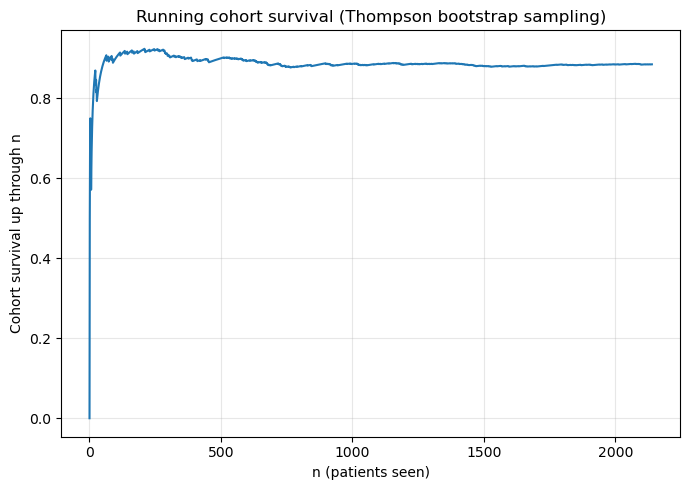

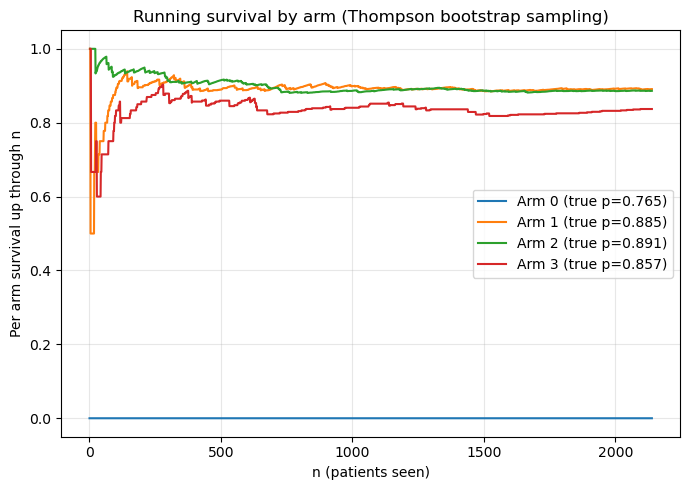

Final simulated overall cohort survival (Thompson bootstrap): 0.884992987377279
Final per arm counts: [   1 1027  976  135]
Final per arm estimated survival: [0.         0.8909445  0.88627049 0.83703704]


In [119]:
true_p = np.array([0.765038, 0.885057, 0.891221, 0.857398])
arms = np.arange(len(true_p))
K = len(arms)

# use same total N as trial
n_per_arm = np.array([532, 522, 524, 561])
N = int(n_per_arm.sum())

print("True survival probs per arm:", true_p)
print("Total patients N:", N)

rng = np.random.default_rng(42)

# reward history per arm (list of 0 or 1)
rewards_hist = [[] for _ in range(K)]

counts = np.zeros(K, dtype=int)
sum_rewards = np.zeros(K, dtype=float)
value_estimates = np.zeros(K, dtype=float)

overall_cum = np.zeros(N)
per_arm_cum = np.full((N, K), np.nan)

total_reward = 0

# Warm up - sample each arm once
for t, a in enumerate(range(K)):
    reward = 1 if rng.random() < true_p[a] else 0

    rewards_hist[a].append(reward)
    counts[a] += 1
    sum_rewards[a] += reward
    value_estimates[a] = sum_rewards[a] / counts[a]

    total_reward += reward
    overall_cum[t] = total_reward / (t + 1)

    for k in range(K):
        if counts[k] > 0:
            per_arm_cum[t, k] = sum_rewards[k] / counts[k]

# Thompson bootstrap sampling loop
for t in range(K, N):
    sampled_means = np.zeros(K)

    for a in range(K):
        rewards_a = np.array(rewards_hist[a])
        idx = rng.integers(len(rewards_a), size=len(rewards_a))
        boot_sample = rewards_a[idx]
        sampled_means[a] = boot_sample.mean()

    # select arm with highest sampled mean
    best_arms = np.flatnonzero(sampled_means == sampled_means.max())
    a = rng.choice(best_arms)

    # simulate survival outcome
    reward = 1 if rng.random() < true_p[a] else 0

    rewards_hist[a].append(reward)
    counts[a] += 1
    sum_rewards[a] += reward
    value_estimates[a] = sum_rewards[a] / counts[a]

    total_reward += reward
    overall_cum[t] = total_reward / (t + 1)

    for k in range(K):
        if counts[k] > 0:
            per_arm_cum[t, k] = sum_rewards[k] / counts[k]


# overall cohort running survival
plt.figure(figsize=(7, 5))
plt.plot(np.arange(1, N + 1), overall_cum)
plt.xlabel("n (patients seen)")
plt.ylabel("Cohort survival up through n")
plt.title("Running cohort survival (Thompson bootstrap sampling)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# per arm running survival estimates
plt.figure(figsize=(7, 5))
for k in range(K):
    plt.plot(
        np.arange(1, N + 1),
        per_arm_cum[:, k],
        label=f"Arm {k} (true p={true_p[k]:.3f})"
    )
plt.xlabel("n (patients seen)")
plt.ylabel("Per arm survival up through n")
plt.title("Running survival by arm (Thompson bootstrap sampling)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Final summary

final_overall_surv = overall_cum[-1]
print("Final simulated overall cohort survival (Thompson bootstrap):",
      final_overall_surv)
print("Final per arm counts:", counts)
print("Final per arm estimated survival:", value_estimates)


We reach a slightly higher overall cohort survival and this time arms 2 and 1 are more selected than the arm 3.

References
Experimentation for Engineers DAVID SWEET Manning 2023